# Predicción de Lluvia en Australia

### Facultad de Ciencias Exactas, Ingeniería y Agrimensura  
### Tecnicatura en Inteligencia Artificial  
### Aprendizaje Automático 1  

**Trabajo Práctico**: Predicción de lluvia utilizando modelos de clasificación y redes neuronales.

**Autores**:  
- Avecilla Tomas 
- Calcia Franco  

 

---

### Objetivo
Desarrollar un modelo de predicción de la variable `RainTomorrow` basado en datos climáticos de Australia, utilizando técnicas de pre-procesamiento, modelado, evaluación y optimización de modelos, para su posterior puesta en producción.



### Diccionario de Datos

| Variable         | Descripción                                                       | Tipo        | Ejemplo       
|-------------------|------------------------------------------------------------------|-------------|---------------
| **Date**          | Fecha de la observación del clima.                               | object      | 2010-01-01    
| **Location**      | Ciudad donde se realizó la medición del clima.                  | object      | Sydney        
| **MinTemp**       | Temperatura mínima del día (en grados Celsius).                 | float64     | 12.3          
| **MaxTemp**       | Temperatura máxima del día (en grados Celsius).                 | float64     | 28.9          
| **Rainfall**      | Cantidad de lluvia caída en milímetros durante el día.          | float64     | 0.0           
| **Evaporation**   | Evaporación en milímetros durante el día.                       | float64     | 0.0           
| **Sunshine**      | Horas de sol durante el día.                                    | float64     | 8.0           
| **WindGustDir**   | Dirección del viento racheado (en grados).                      | object      | NNE           
| **WindGustSpeed** | Velocidad del viento racheado (en km/h).                        | float64     | 15.0          
| **WindDir9am**    | Dirección del viento a las 9 am.                                | object      | NNE           
| **WindDir3pm**    | Dirección del viento a las 3 pm.                                | object      | SSE          
| **WindSpeed9am**  | Velocidad del viento a las 9 am (en km/h).                     | float64     | 5.0           
| **WindSpeed3pm**  | Velocidad del viento a las 3 pm (en km/h).                     | float64     | 10.0          
| **Humidity9am**   | Humedad relativa a las 9 am (%).                               | float64     | 65.0          
| **Humidity3pm**   | Humedad relativa a las 3 pm (%).                               | float64     | 55.0          
| **Pressure9am**   | Presión atmosférica a las 9 am (hPa).                          | float64     | 1012.0        
| **Pressure3pm**   | Presión atmosférica a las 3 pm (hPa).                          | float64     | 1011.0        
| **Cloud9am**      | Cobertura nubosa a las 9 am (en octavos).                      | float64     | 2.0           
| **Cloud3pm**      | Cobertura nubosa a las 3 pm (en octavos).                      | float64     | 3.0           
| **Temp9am**       | Temperatura a las 9 am (en grados Celsius).                    | float64     | 15.0          
| **Temp3pm**       | Temperatura a las 3 pm (en grados Celsius).                    | float64     | 20.0          
| **RainToday**     | Indica si llovió hoy (Yes/No).                                 | object      | Yes           
| **RainTomorrow** _(Target)_ | Indica si lloverá mañana (Yes/No).                             | object      | No            


## Preparación del entorno de trabajo

In [388]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.dummy import DummyClassifier

In [389]:
df_clima = pd.read_csv("weatherAUS.csv")

In [390]:
#Al tener la funcion Random, cada vez que se ejecuta el codigo, van a variar los resultados
# Obtener los valores únicos de la columna 'Location'
unique_locations = df_clima['Location'].unique()
print("Ciudades únicas disponibles:", unique_locations)

# Seleccionar aleatoriamente 10 ciudades de los valores únicos
random_cities = random.sample(list(unique_locations), 10)
print("Ciudades seleccionadas:", random_cities)

# Filtrar el DataFrame para quedarse solo con las ciudades seleccionadas
df_filtered = df_clima[df_clima['Location'].isin(random_cities)]



Ciudades únicas disponibles: ['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']
Ciudades seleccionadas: ['Albury', 'AliceSprings', 'PerthAirport', 'Ballarat', 'NorahHead', 'Darwin', 'Sale', 'Dartmoor', 'Woomera', 'Moree']


## Análisis Descriptivo

In [391]:
df_filtered.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [392]:
# Resumen de estadísticas descriptivas
stats = df_filtered.describe().T
stats['missing_values'] = df_filtered.isnull().sum()
stats = stats.round(2)
stats.head(35)


,count,mean,std,min,25%,50%,75%,max,missing_values
MinTemp,30242.0,12.53,7.02,-5.6,7.1,11.9,17.9,31.8,120
MaxTemp,30250.0,24.49,7.77,4.6,18.2,23.9,31.2,48.1,112
Rainfall,29989.0,2.07,7.73,0.0,0.0,0.0,0.4,367.6,373
Evaporation,18268.0,6.67,5.45,0.0,3.2,5.6,8.6,82.4,12094
Sunshine,17159.0,8.33,3.64,0.0,6.0,9.4,11.0,14.3,13203
WindGustSpeed,29780.0,41.08,13.32,9.0,31.0,39.0,48.0,135.0,582
WindSpeed9am,30184.0,15.29,9.19,0.0,9.0,15.0,20.0,87.0,178
WindSpeed3pm,30193.0,19.61,8.77,0.0,13.0,19.0,24.0,74.0,169
Humidity9am,30024.0,67.45,22.22,0.0,53.0,70.0,85.0,100.0,338
Humidity3pm,30035.0,47.43,23.10,0.0,29.0,47.0,64.0,100.0,327


**Descripción rápida de los datos:**
Este conjunto de datos contiene información meteorológica con un número considerable de valores faltantes. Algunas variables como la evaporación, la luz solar y la cobertura nubosa tienen un porcentaje elevado de datos faltantes, mientras que otras, como la temperatura y la humedad, tienen menos valores nulos.

In [393]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30362 entries, 0 to 142303
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           30362 non-null  object 
 1   Location       30362 non-null  object 
 2   MinTemp        30242 non-null  float64
 3   MaxTemp        30250 non-null  float64
 4   Rainfall       29989 non-null  float64
 5   Evaporation    18268 non-null  float64
 6   Sunshine       17159 non-null  float64
 7   WindGustDir    29775 non-null  object 
 8   WindGustSpeed  29780 non-null  float64
 9   WindDir9am     28554 non-null  object 
 10  WindDir3pm     30055 non-null  object 
 11  WindSpeed9am   30184 non-null  float64
 12  WindSpeed3pm   30193 non-null  float64
 13  Humidity9am    30024 non-null  float64
 14  Humidity3pm    30035 non-null  float64
 15  Pressure9am    30206 non-null  float64
 16  Pressure3pm    30201 non-null  float64
 17  Cloud9am       20445 non-null  float64
 18  Cloud3pm  

El DataFrame contiene 23 columnas, de las cuales 16 son de tipo numérico (float64) y 7 de tipo categórico (object). Como primer paso, convertiremos el tipo de dato de la columna 'Date' a un formato de fecha adecuado y luego ordenaremos el dataset en orden ascendente.

In [394]:
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

df_filtered = df_filtered.sort_values(by='Date', ascending=True)

C:\Users\franco\AppData\Local\Temp\ipykernel_20292\4025393556.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])


In [395]:

df_filtered = pd.get_dummies(df_filtered, columns=['RainToday', 'RainTomorrow'], drop_first=True)
# Renombrar las columnas
df_filtered = df_filtered.rename(columns={'RainToday_Yes': 'RainToday', 'RainTomorrow_Yes': 'RainTomorrow'})
# Convertir las columnas RainToday y RainTomorrow a 0 y 1
df_filtered['RainToday'] = df_filtered['RainToday'].astype(int)
df_filtered['RainTomorrow'] = df_filtered['RainTomorrow'].astype(int)

Vamos a analizar el comportamiento de nuestras variables numéricas para identificar tendencias o distribuciones. 

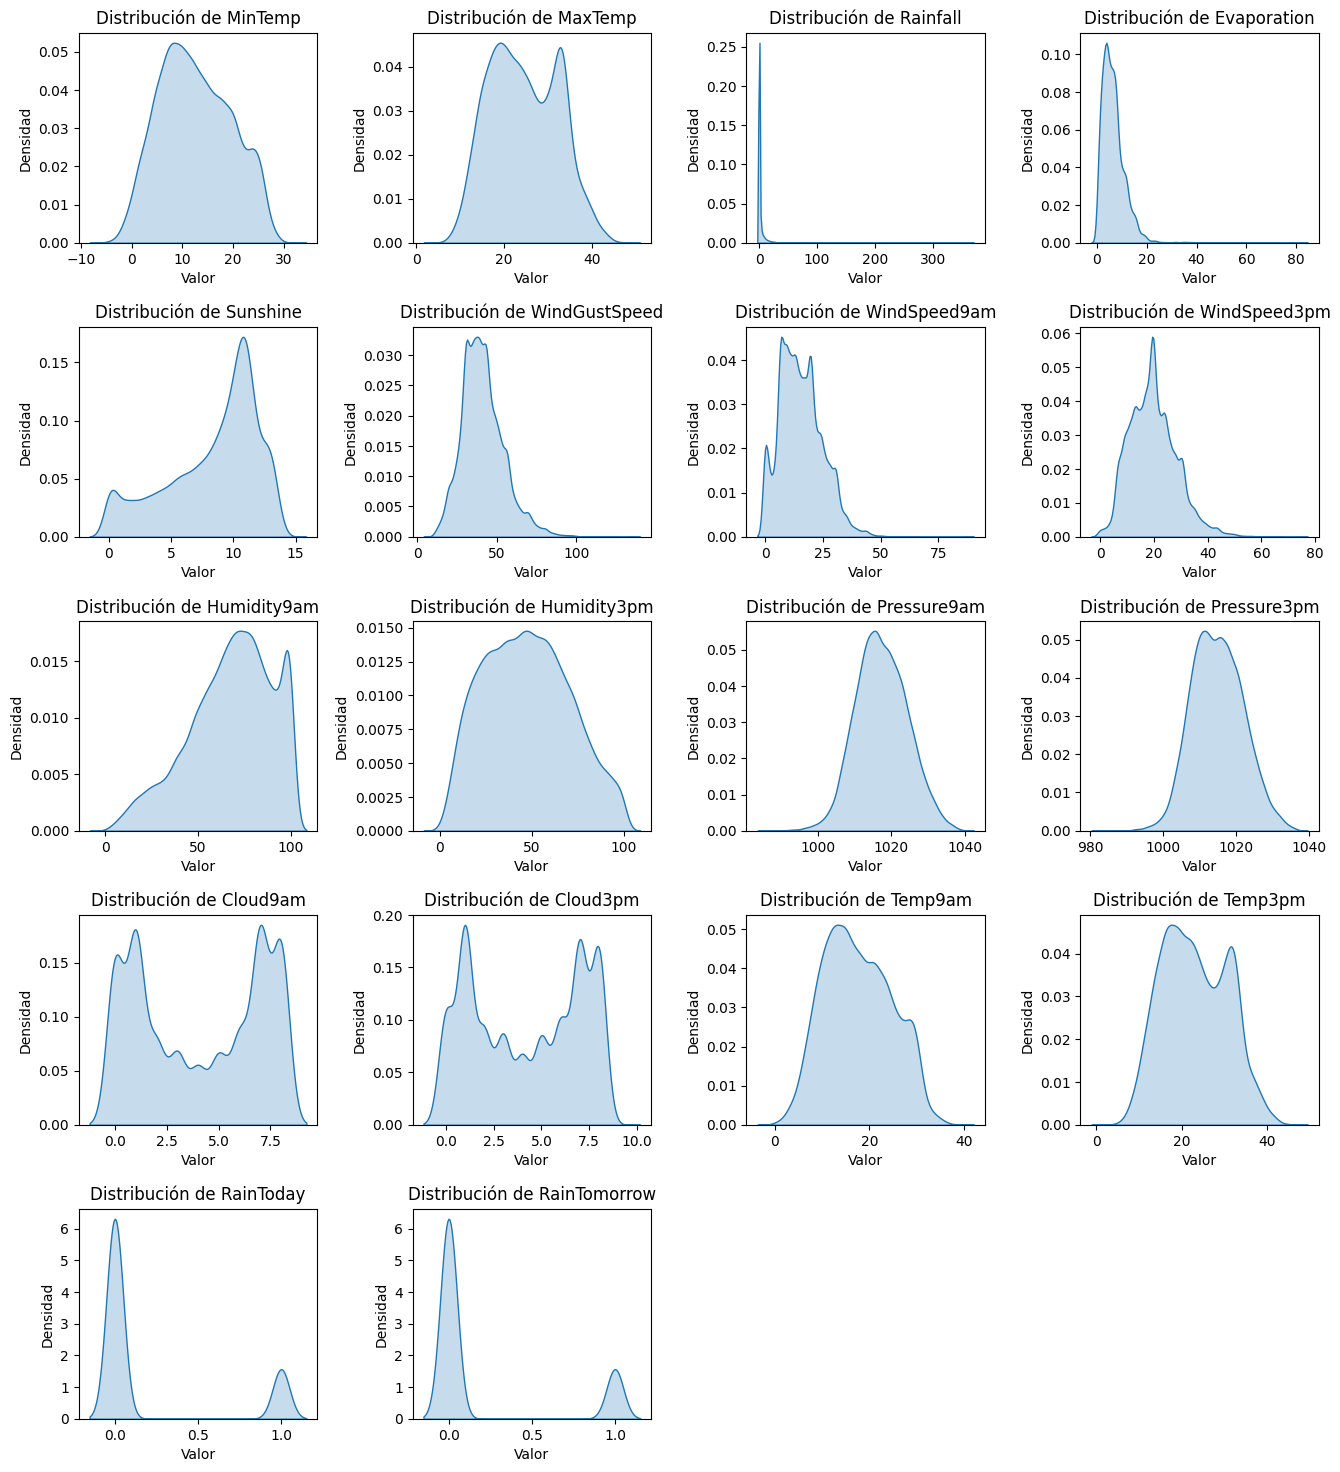

In [396]:
# Filtrar las columnas numéricas del dataframe
df_numerico = df_filtered.select_dtypes(include=['float64', 'int64'])

# Determinar el número de variables numéricas
num_vars = len(df_numerico.columns)

# Configurar la figura y las subplots
fig, axes = plt.subplots(nrows=(num_vars // 4) + (num_vars % 4 > 0), ncols=4, figsize=(16, num_vars))

# Ajustar espacio entre los gráficos
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Recorrer las columnas y plotear cada una en su propio subplot
for i, column in enumerate(df_numerico.columns):
    row, col = divmod(i, 4)
    sns.kdeplot(df_numerico[column], ax=axes[row, col], fill=True)
    axes[row, col].set_title(f'Distribución de {column}')
    axes[row, col].set_xlabel('Valor')
    axes[row, col].set_ylabel('Densidad')

# Eliminar gráficos vacíos si no se llena la última fila
for j in range(i + 1, axes.size):
    fig.delaxes(axes.flat[j])

plt.show()


Al analizar las distribuciones de las variables numéricas a través de gráficos de KDE, observamos varios patrones.

1. **Distribuciones Normales**:
   Algunas variables muestran una distribución simétrica, similar a la curva de campana característica de la **distribución normal**.

2. **Distribuciones Asimétricas (Sesgo)**:
   Otras variables presentan **sesgo**, ya sea positivo o negativo..
   
   - **Implicación**: Estas variables pueden requerir transformaciones para mejorar su simetría. Esto facilitará la aplicabilidad para los modelos.

3. **Distribuciones Multimodales**:
   Se observan algunas variables con **distribuciones multimodales**, es decir, con varios picos en su densidad. Esto podría sugerir la existencia de **subgrupos** lo cual es normal ya que los datos son climaticos y puede llegar a tener algo que ver con las estaciones.

4. **Presencia de Outliers**:
   Varias variables muestran distribuciones con **colas largas**, lo que indica la presencia de **outliers** lo cual nos confirma lo que fue analizado anteriormente.



## Analisis exploratorio

Viendo que las columnas 'WindGustDir', 'WindDir9am' y 'WindDir3pm' son variables categóricas (tipo object), evaluaremos su correlación con nuestra variable objetivo. Esto nos ayudará a decidir si es conveniente eliminarlas o mantenerlas, con el objetivo de reducir la complejidad del modelo y evitar posibles problemas en la etapa de predicción.

C:\Users\franco\AppData\Local\Temp\ipykernel_20292\3675620961.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations_with_rain.index, y=correlations_with_rain.values, palette='coolwarm')


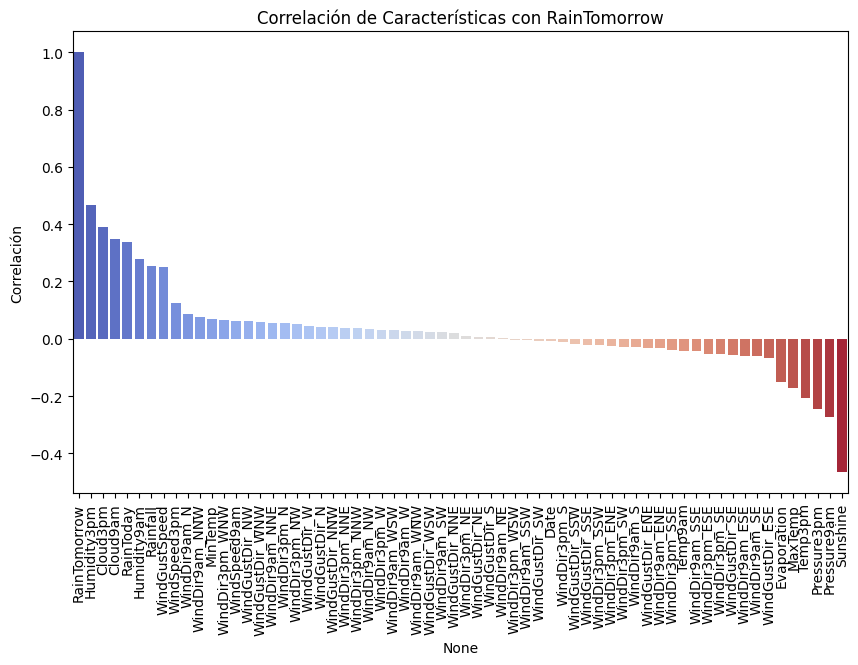

In [397]:
# Eliminar la columna 'Location'
df_without_location = df_filtered.drop(columns=['Location'])
# Aplicar One-Hot Encoding
df_encoded = pd.get_dummies(df_without_location, columns=['WindGustDir', 'WindDir9am', 'WindDir3pm'], drop_first=True)

# Calcular la matriz de correlación
correlation_matrix = df_encoded.corr()

# Mostrar correlación con 'RainTomorrow'
# Ordenar las correlaciones con 'RainTomorrow'
correlations_with_rain = correlation_matrix['RainTomorrow'].sort_values(ascending=False)

# Crear un gráfico de barras para visualizar la correlación de cada característica con 'RainTomorrow'
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations_with_rain.index, y=correlations_with_rain.values, palette='coolwarm')
plt.xticks(rotation=90)
plt.title('Correlación de Características con RainTomorrow')
plt.ylabel('Correlación')
plt.show()

Es evidente que estas variables no tendrían un impacto significativo en el rendimiento del modelo. Por lo tanto, procederemos a eliminarlas para simplificar el conjunto de datos y evitar complicaciones en el proceso de predicción.

In [398]:
columnas = ['WindDir9am', 'WindDir3pm', 'WindGustDir']

# Dropear las columnas
df_filtered = df_filtered.drop(columns=columnas)

Para la variable categórica 'Location', calculamos la proporción de cada localidad en relación con nuestra variable objetivo. Esto nos permitió evaluar cómo cada ubicación podría influir en la predicción.

In [399]:
df_filtered['Location'] = df_filtered['Location'].fillna('Categoria_Nula')

mean_encoded_location_today = df_filtered.groupby('Location')['RainTomorrow'].mean()

df_filtered['Location'] = df_filtered['Location'].map(mean_encoded_location_today)

Al observar los valores faltantes, calculamos el porcentaje de datos faltantes en cada columna. 

In [400]:
conteo_nan = df_filtered.isnull().sum()
# Que porcentaje del total de cada columna hay valores faltantes
nan_percentage = (conteo_nan / len(df_filtered)) * 100
missing_data = pd.DataFrame({'count': conteo_nan, 'percentage': nan_percentage})
print(missing_data)

               count  percentage
Date               0    0.000000
Location           0    0.000000
MinTemp          120    0.395231
MaxTemp          112    0.368882
Rainfall         373    1.228509
Evaporation    12094   39.832686
Sunshine       13203   43.485278
WindGustSpeed    582    1.916870
WindSpeed9am     178    0.586259
WindSpeed3pm     169    0.556617
Humidity9am      338    1.113234
Humidity3pm      327    1.077004
Pressure9am      156    0.513800
Pressure3pm      161    0.530268
Cloud9am        9917   32.662539
Cloud3pm       10497   34.572821
Temp9am          129    0.424873
Temp3pm          118    0.388644
RainToday          0    0.000000
RainTomorrow       0    0.000000


Algunas variables, como 'Evaporation', 'Sunshine', 'Cloud9am' y 'Cloud3pm', tienen un porcentaje considerable de datos faltantes, mientras que otras, como 'MinTemp', 'MaxTemp' o 'Rainfall', presentan menos valores faltantes.

### Limpieza de Datos

Como primera medida, eliminaremos las filas que tengan valores nulos en la variable objetivo o aquellas que presenten 18 o más columnas con valores nulos, ya que las consideramos irrelevantes para el análisis.

In [401]:
#Mantenemos las filas que contengan 18 o menos valores nulos
df_filtered = df_filtered.dropna(thresh=18)

#Eliminamos las filas que contienen la variable Target como nula
df_filtered = df_filtered.dropna(subset=['RainTomorrow'])

A continuación, realizaremos la división de los datos, ya que consideramos que es un paso necesario en este punto. Sin embargo, continuaremos con el análisis exploratorio y la limpieza de los datos una vez realizada esta división.

### Train-Test

In [402]:
X_train, X_test, y_train, y_test = train_test_split(df_filtered.drop(columns=['RainTomorrow']), df_filtered['RainTomorrow'], test_size=0.3, random_state=42)

#Validacion
X_train, X_temp, y_train, y_temp = train_test_split(
    df_filtered.drop(columns=['RainTomorrow']),
    df_filtered['RainTomorrow'],
    test_size=0.3,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5, 
    random_state=42
)

# Concatenar para tener dataframes completos
df_entrenamiento = pd.concat([X_train, y_train], axis=1)
df_validacion = pd.concat([X_val, y_val], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

Decidimos imputar las variables que tienen menos de 1000 valores faltantes utilizando la media, ya que el porcentaje que representan en relación con el total de filas es insignificante y no debería afectar el análisis o los resultados del modelo de manera considerable.

In [403]:
# Identificar las columnas con menos de 1000 nulos
cols_with_few_nans = df_entrenamiento.columns[df_entrenamiento.isnull().sum() < 1000]
medias = {}

for col in cols_with_few_nans:
    if df_entrenamiento[col].dtype in ['float64', 'int64']:  # Solo columnas numéricas
        media = df_entrenamiento[col].mean()  # Calcular la media
        df_entrenamiento[col] = df_entrenamiento[col].fillna(media) 
        medias[col] = media


In [404]:
nan_count_train = df_entrenamiento.isnull().sum()
nan_count_train

Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation      2616
Sunshine         3278
WindGustSpeed       0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am         1718
Cloud3pm         1968
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
dtype: int64

Todavia contamos con columnas que presentan algunos valores nulos. Antes de tomar decisiones sobre cómo manejarlas, analizaremos su distribución para evaluar si es conveniente imputarlas o eliminarlas, con el fin de tomar una decisión informada que no afecte negativamente el análisis o el rendimiento del modelo.

<Axes: xlabel='Evaporation', ylabel='Density'>

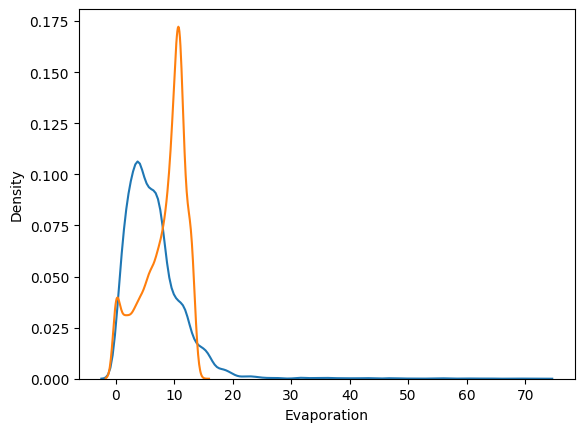

In [405]:
sns.kdeplot(df_entrenamiento["Evaporation"])
sns.kdeplot(df_entrenamiento["Sunshine"])

Podemos observar una clara distribución asimétrica a la derecha. Por lo tanto, optaremos por imputar los valores nulos utilizando la mediana, ya que este enfoque es más robusto frente a los valores atípicos y proporciona una estimación más representativa de los datos.

In [406]:
# Imputar los valores faltantes en 'Evaporation' y 'Sunshine' con la mediana
mediana_evaporation = df_entrenamiento['Evaporation'].median()
mediana_sunshine= df_entrenamiento['Sunshine'].median()

df_entrenamiento['Evaporation'] = df_entrenamiento['Evaporation'].fillna(mediana_evaporation)
df_entrenamiento['Sunshine'] = df_entrenamiento['Sunshine'].fillna(mediana_sunshine)


Aplicamos lo mismo para las demás columnas.

<Axes: xlabel='Cloud3pm', ylabel='Density'>

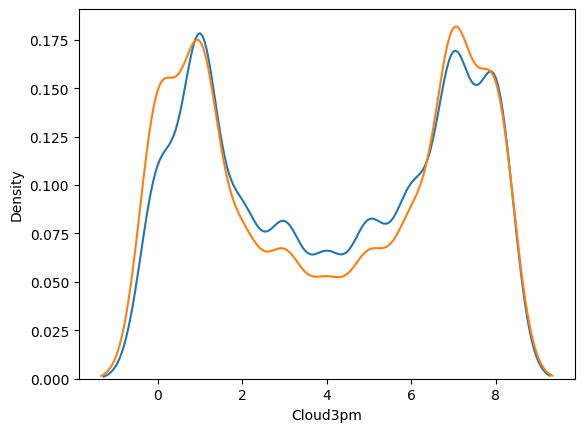

In [407]:
sns.kdeplot(df_entrenamiento["Cloud3pm"])
sns.kdeplot(df_entrenamiento["Cloud9am"])

Debido a la presencia de valores extremos en nuestras variables, decidimos utilizar la mediana para la imputación de datos nulos, ya que este enfoque proporciona una representación más confiable del 'valor central' y minimiza la influencia de los outliers en los resultados.

In [408]:
# Calcular la mediana en lugar de la media móvil en el conjunto de entrenamiento
cloud9am_median = df_entrenamiento['Cloud9am'].median()
cloud3pm_median = df_entrenamiento['Cloud3pm'].median()

df_entrenamiento['Cloud9am'] = df_entrenamiento['Cloud9am'].fillna(cloud9am_median)
df_entrenamiento['Cloud3pm'] = df_entrenamiento['Cloud3pm'].fillna(cloud3pm_median)

<Axes: xlabel='Cloud3pm', ylabel='Density'>

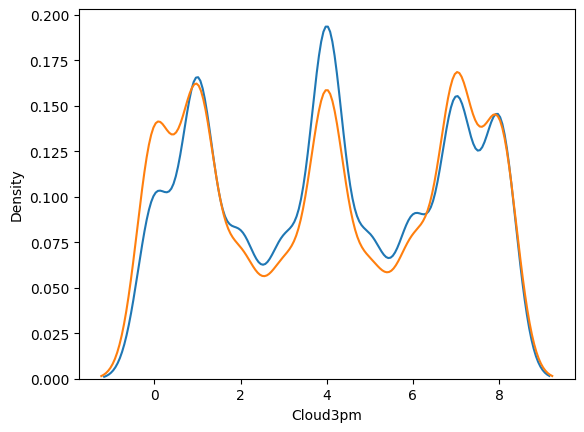

In [409]:
sns.kdeplot(df_entrenamiento["Cloud3pm"])
sns.kdeplot(df_entrenamiento["Cloud9am"])

In [410]:
nan_count_train = df_entrenamiento.isnull().sum()
nan_count_train

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64


Por último, realizaremos un análisis de la variable 'WindGustSpeed'. Esto lo hacemos porque dependiendo las localidades elegidas aleatoriamente podemos contener valores nulos o no.

In [411]:
df_entrenamiento["WindGustSpeed"].describe()

count    14992.000000
mean        41.692396
std         12.758875
min         11.000000
25%         33.000000
50%         41.000000
75%         48.000000
max        126.000000
Name: WindGustSpeed, dtype: float64


Elegimos la mediana para imputar los valores nulos de esta variable porque la desviación estándar es alta en comparación con la media, lo que indica variabilidad y la posible presencia de valores atípicos. La mediana es menos sensible a estos extremos y proporciona un valor central más representativo para la variable.

In [412]:
median_WindGustSpeed = df_entrenamiento['WindGustSpeed'].median()
df_entrenamiento['WindGustSpeed'] = df_entrenamiento['WindGustSpeed'].fillna(median_WindGustSpeed)


In [413]:

nan_count_train = df_entrenamiento.isnull().sum()
nan_count_train

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

#### Outliers

In [414]:
resultados_atipicos = {}

for columna in df_entrenamiento.columns:
    if df_entrenamiento[columna].dtype in ['int64', 'float64']:
        Q1 = df_entrenamiento[columna].quantile(0.25)
        Q3 = df_entrenamiento[columna].quantile(0.75)
        IQR = Q3 - Q1

        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        es_atipico = (df_entrenamiento[columna] < limite_inferior) | (df_entrenamiento[columna] > limite_superior)

        cantidad_atipicos = es_atipico.sum()
        porcentaje_atipicos = (cantidad_atipicos / len(df_entrenamiento)) * 100

        resultados_atipicos[columna] = porcentaje_atipicos

for columna, porcentaje in resultados_atipicos.items():
    print(f"Columna: {columna} - Porcentaje de valores atípicos: {porcentaje:.2f}%")

Columna: Location - Porcentaje de valores atípicos: 0.00%
Columna: MinTemp - Porcentaje de valores atípicos: 0.00%
Columna: MaxTemp - Porcentaje de valores atípicos: 0.00%
Columna: Rainfall - Porcentaje de valores atípicos: 19.13%
Columna: Evaporation - Porcentaje de valores atípicos: 5.00%
Columna: Sunshine - Porcentaje de valores atípicos: 6.94%
Columna: WindGustSpeed - Porcentaje de valores atípicos: 2.73%
Columna: WindSpeed9am - Porcentaje de valores atípicos: 0.60%
Columna: WindSpeed3pm - Porcentaje de valores atípicos: 3.05%
Columna: Humidity9am - Porcentaje de valores atípicos: 0.00%
Columna: Humidity3pm - Porcentaje de valores atípicos: 0.00%
Columna: Pressure9am - Porcentaje de valores atípicos: 0.59%
Columna: Pressure3pm - Porcentaje de valores atípicos: 0.43%
Columna: Cloud9am - Porcentaje de valores atípicos: 0.00%
Columna: Cloud3pm - Porcentaje de valores atípicos: 0.00%
Columna: Temp9am - Porcentaje de valores atípicos: 0.00%
Columna: Temp3pm - Porcentaje de valores atípi

Observamos que en la mayoría de las columnas no hay una cantidad significativa de valores atípicos, por lo que decidimos no realizar ningún tratamiento sobre ellos.

A continuación, analizaremos la distribución de la variable objetivo.

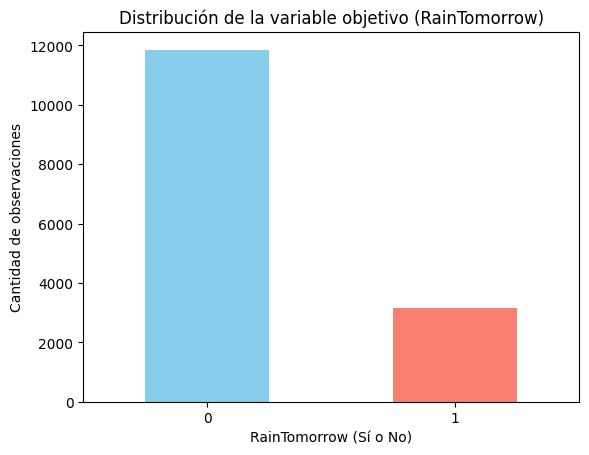

In [415]:
df_entrenamiento['RainTomorrow'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])

plt.title('Distribución de la variable objetivo (RainTomorrow)')
plt.xlabel('RainTomorrow (Sí o No)')
plt.ylabel('Cantidad de observaciones')
plt.xticks(rotation=0)
plt.show()


Observamos una marcada diferencia entre los dos valores de la variable objetivo, lo que indica que el conjunto de datos **está desbalanceado**. Además, es importante analizar la tasa de aciertos en las predicciones del dataset.

Predicción Acertada
True     9981
False    5011
Name: count, dtype: int64


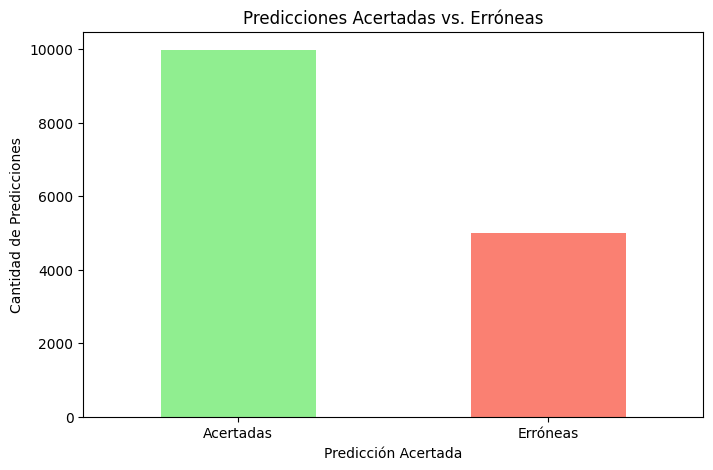

In [416]:
# Crear una copia de las columnas relevantes
df_aciertos = df_entrenamiento[['RainToday', 'RainTomorrow']].copy()

# Comparar RainToday de la fila actual con RainTomorrow de la fila anterior
# shift() mueve la columna RainTomorrow una fila hacia abajo
df_aciertos['Predicción Acertada'] = df_aciertos['RainToday'] == df_aciertos['RainTomorrow'].shift(1)

# Contar las predicciones acertadas y erróneas
conteo_aciertos = df_aciertos['Predicción Acertada'].value_counts()

# Mostrar conteo de aciertos
print(conteo_aciertos)

# Graficar los resultados
plt.figure(figsize=(8, 5))
conteo_aciertos.plot(kind='bar', color=['lightgreen', 'salmon'])

plt.title('Predicciones Acertadas vs. Erróneas')
plt.xlabel('Predicción Acertada')
plt.ylabel('Cantidad de Predicciones')
plt.xticks(ticks=[0, 1], labels=['Acertadas', 'Erróneas'], rotation=0)

plt.show()


Considerando la información proporcionada por las variables, analizamos la precisión de las 'predicciones' sobre si lloverá mañana. Observamos que se ha logrado una predicción con cierto grado de efectividad, aunque hay margen para mejorar.

### Matriz de correlación


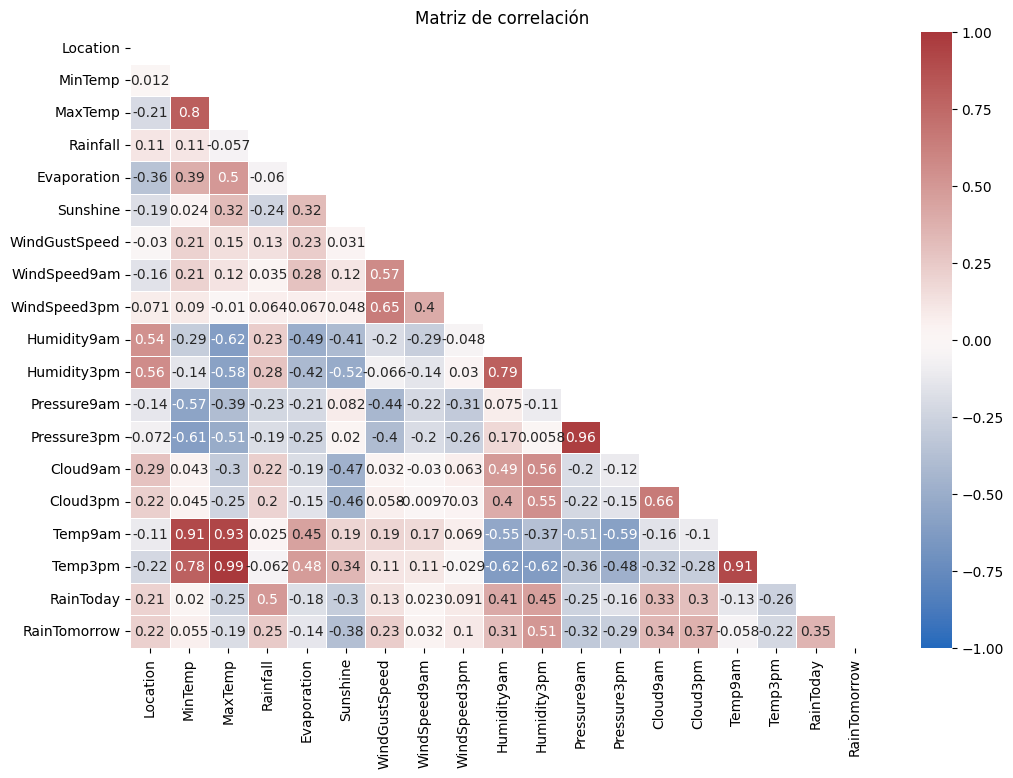

In [417]:
df_numerico = df_entrenamiento.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación
corr_matrix = df_numerico.corr()

# Crear la máscara
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Crear el colormap
colors = [(1, 1, 1), (1, 0, 0)]
n_bins = 100
cmap_name = 'red_white'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Graficar el heatmap de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='vlag', center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()


Decidimos eliminar las columnas 'Temp9am' y 'Temp3pm', ya que contamos con 'MinTemp' y 'MaxTemp' para todo el día, y su correlación sugiere que son redundantes. De manera similar, considerando la correlación entre 'Pressure9am' y 'Pressure3pm', optamos por conservar solo una de ellas.

In [418]:
df_entrenamiento = df_entrenamiento.drop(columns=['Temp9am', 'Temp3pm', 'Pressure9am'])

### Limpieza de datos para df_test y df_validacion

Todas las imputaciones y limpiezas de datos que realizamos para el conjunto de entrenamiento también se aplicarán a los conjuntos de prueba y validación, asegurando consistencia en el procesamiento de los datos.

In [419]:
for col, media in medias.items():
    if col in df_validacion.columns:   
        df_validacion[col] = df_validacion[col].fillna(media)  
for col, media in medias.items():
    if col in df_test.columns:  
        df_test[col] = df_test[col].fillna(media)


df_test["Evaporation"] = df_test["Evaporation"].fillna(mediana_evaporation)
df_test["Sunshine"] = df_test["Sunshine"].fillna(mediana_sunshine)
df_validacion["Evaporation"] = df_validacion["Evaporation"].fillna(mediana_evaporation)
df_validacion["Sunshine"] = df_validacion["Sunshine"].fillna(mediana_sunshine)


df_test['Cloud9am'] = df_test['Cloud9am'].fillna(cloud9am_median)
df_test['Cloud3pm'] = df_test['Cloud3pm'].fillna(cloud3pm_median)
df_validacion['Cloud9am'] = df_validacion['Cloud9am'].fillna(cloud9am_median)
df_validacion['Cloud3pm'] = df_validacion['Cloud3pm'].fillna(cloud3pm_median)


df_test['WindGustSpeed'] = df_test['WindGustSpeed'].fillna(median_WindGustSpeed)
df_validacion['WindGustSpeed'] = df_validacion['WindGustSpeed'].fillna(median_WindGustSpeed)


df_test = df_test.drop(columns=['Temp9am', 'Temp3pm', 'Pressure9am'])
df_validacion = df_validacion.drop(columns=['Temp9am', 'Temp3pm', 'Pressure9am'])


Finalmente, para mejorar nuestras predicciones futuras, decidimos dividir la columna 'Date' en componentes como mes, día, año, día de la semana y día del año. No realizamos esta división anteriormente para evitar que se mostrara en la matriz de correlación.

In [420]:
# Extraer características de fecha para df_entrenamiento
df_entrenamiento['Year'] = df_entrenamiento['Date'].dt.year
df_entrenamiento['Month'] = df_entrenamiento['Date'].dt.month
df_entrenamiento['Day'] = df_entrenamiento['Date'].dt.day
df_entrenamiento['DayOfWeek'] = df_entrenamiento['Date'].dt.dayofweek  # Lunes = 0, Domingo = 6
df_entrenamiento['DayOfYear'] = df_entrenamiento['Date'].dt.dayofyear

# Extraer características de fecha para df_validacion
df_validacion['Year'] = df_validacion['Date'].dt.year
df_validacion['Month'] = df_validacion['Date'].dt.month
df_validacion['Day'] = df_validacion['Date'].dt.day
df_validacion['DayOfWeek'] = df_validacion['Date'].dt.dayofweek  # Lunes = 0, Domingo = 6
df_validacion['DayOfYear'] = df_validacion['Date'].dt.dayofyear

# Extraer características de fecha para df_test
df_test['Year'] = df_test['Date'].dt.year
df_test['Month'] = df_test['Date'].dt.month
df_test['Day'] = df_test['Date'].dt.day
df_test['DayOfWeek'] = df_test['Date'].dt.dayofweek  # Lunes = 0, Domingo = 6
df_test['DayOfYear'] = df_test['Date'].dt.dayofyear

# Dropear la columna 'Date' de df_entrenamiento
df_entrenamiento = df_entrenamiento.drop(columns=['Date'])

# Dropear la columna 'Date' de df_validacion
df_validacion = df_validacion.drop(columns=['Date'])

# Dropear la columna 'Date' de df_test
df_test = df_test.drop(columns=['Date'])

In [421]:
df_entrenamiento.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14992 entries, 61832 to 83041
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       14992 non-null  float64
 1   MinTemp        14992 non-null  float64
 2   MaxTemp        14992 non-null  float64
 3   Rainfall       14992 non-null  float64
 4   Evaporation    14992 non-null  float64
 5   Sunshine       14992 non-null  float64
 6   WindGustSpeed  14992 non-null  float64
 7   WindSpeed9am   14992 non-null  float64
 8   WindSpeed3pm   14992 non-null  float64
 9   Humidity9am    14992 non-null  float64
 10  Humidity3pm    14992 non-null  float64
 11  Pressure3pm    14992 non-null  float64
 12  Cloud9am       14992 non-null  float64
 13  Cloud3pm       14992 non-null  float64
 14  RainToday      14992 non-null  int64  
 15  RainTomorrow   14992 non-null  int64  
 16  Year           14992 non-null  int32  
 17  Month          14992 non-null  int32  
 18  Day    

## Escalado

Optamos por Min-Max Scaling porque normaliza los valores dentro de un rango de 0 a 1. Esta técnica ayuda a que los algoritmos de aprendizaje automático converjan más rápidamente y mejora la estabilidad del modelo durante el entrenamiento.

In [422]:
scaler = RobustScaler()

df_train_scaled = pd.DataFrame(scaler.fit_transform(df_entrenamiento), columns=df_entrenamiento.columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)
df_val_scaled = pd.DataFrame(scaler.transform(df_validacion), columns=df_validacion.columns)

df_train_scaled.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,Pressure3pm,Cloud9am,Cloud3pm,RainToday,RainTomorrow,Year,Month,Day,DayOfWeek,DayOfYear
0,0.135378,0.113043,-0.359712,2.000000,-0.476190,-2.685714,-0.666667,-0.615385,-0.555556,0.558824,...,0.000000,0.666667,0.8,1.0,1.0,-0.50,0.8,-0.200000,-0.25,0.602273
1,0.079620,0.260870,0.136691,0.000000,0.000000,0.000000,-0.266667,-0.692308,0.666667,-0.352941,...,0.303030,0.666667,0.4,0.0,0.0,0.75,-0.4,-0.933333,0.00,-0.500000
2,-0.579789,0.695652,0.978417,0.000000,1.904762,0.028571,-0.400000,0.384615,-0.777778,-1.205882,...,-0.666667,0.333333,0.0,0.0,0.0,0.75,1.2,-0.200000,0.75,0.948864
3,0.632358,-0.373913,-0.683453,1.333333,-1.190476,-2.028571,0.133333,0.384615,0.444444,0.529412,...,0.818182,0.000000,0.0,0.0,0.0,-0.75,1.0,-0.800000,-0.25,0.727273
4,0.632358,-0.182609,0.374101,0.000000,0.142857,0.971429,-0.533333,-0.461538,-0.777778,0.117647,...,0.474747,0.000000,0.0,0.0,0.0,1.00,-0.8,-0.466667,-0.50,-0.795455


## Modelado

In [423]:
X_train_scaled = df_train_scaled.drop('RainTomorrow', axis=1)
y_train_scaled = df_train_scaled['RainTomorrow']

X_test_scaled = df_test_scaled.drop('RainTomorrow', axis=1)
y_test_scaled = df_test_scaled['RainTomorrow']

X_val_scaled = df_val_scaled.drop('RainTomorrow', axis=1)
y_val_scaled = df_val_scaled['RainTomorrow']

Aplicamos 'LogisticRegression'

In [424]:
# Inicializar y entrenar el modelo
model = LogisticRegression()
model.fit(X_train_scaled, y_train_scaled)

LogisticRegression()

Procedemos a calcular nuestras métricas adecuadas.

In [425]:
# Predicciones
y_pred = model.predict(X_test_scaled)  
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
# Cálculo de métricas
accuracy = accuracy_score(y_test_scaled, y_pred)
precision = precision_score(y_test_scaled, y_pred)
recall = recall_score(y_test_scaled, y_pred)
f1 = f1_score(y_test_scaled, y_pred)

# Mostrar las métricas
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.87
Precision: 0.73
Recall: 0.58
F1 Score: 0.65


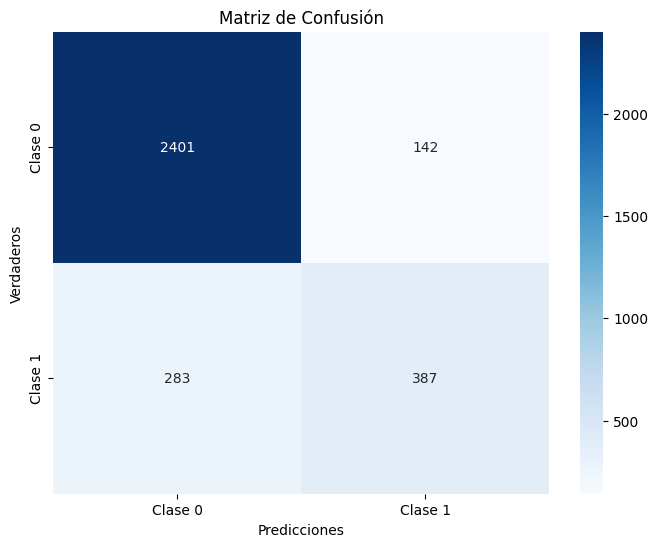

In [426]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test_scaled, y_pred)
# Graficar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Clase 0', 'Clase 1'], 
            yticklabels=['Clase 0', 'Clase 1'])
plt.ylabel('Verdaderos')
plt.xlabel('Predicciones')
plt.title('Matriz de Confusión')
plt.show()

### Interpretación de las celdas:

- **Verdaderos negativos (Clase 0 predicha como Clase 0):** ≈2401
  - El modelo predijo correctamente que no lloverá.
  
- **Falsos positivos (Clase 0 predicha como Clase 1):** ≈142
  - El modelo predijo que va a llover, pero en realidad no lloverá.

- **Falsos negativos (Clase 1 predicha como Clase 0):** ≈283
  - El modelo predijo que no va a llover, pero en realidad sí lloverá.

- **Verdaderos positivos (Clase 1 predicha como Clase 1):** ≈387
  - El modelo predijo correctamente que va a llover.


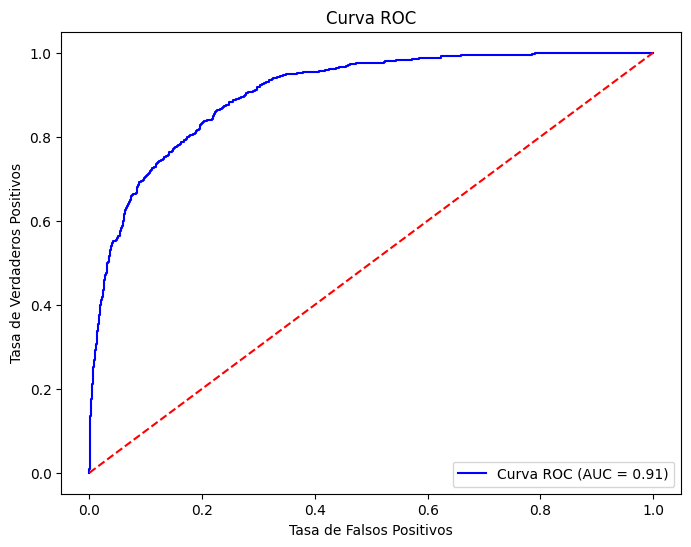

Mejor umbral: 0.16


In [427]:
# Cálculo de la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_scaled, y_pred_proba)
roc_auc = roc_auc_score(y_test_scaled, y_pred_proba)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Encontrar el mejor umbral
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Mejor umbral: {optimal_threshold:.2f}")


- Trazamos la curva ROC para el modelo, y la AUC fue de aproximadamente 0.91, lo que indica que el modelo tiene una buena capacidad para diferenciar entre las clases.  
- Calculamos el mejor umbral, que resultó ser **≈0.16**, lo que significa que para predecir lluvia, el modelo requiere una probabilidad de al menos **≈0.16**.

#### **Evaluación del Fitting**:
- En cuanto al fitting, el modelo tiene una **accuracy** de **≈0.87**, lo que refleja un rendimiento general sólido. Sin embargo, presenta una **precision** de **≈0.73** y un **recall** de **≈0.58**. Esto sugiere que el modelo predice correctamente la clase positiva en el 74% de los casos, pero le falta capturar una proporción más alta de días lluviosos.
- El **F1 Score** de **≈0.65** refuerza la idea de que hay un equilibrio moderado entre precision y recall, pero aún queda espacio para mejorar en la detección de días lluviosos.
- La matriz de confusión indica un número considerable de falsos negativos, lo que confirma que el modelo no está completamente ajustado para predecir de manera precisa la clase positiva (días lluviosos).
- En general, aunque el modelo ofrece una buena accuracy, el bajo recall y los falsos negativos sugieren que aún necesita mejoras para predecir con mayor fiabilidad los días con lluvia.


## Modelo Base

Para nuestro modelo base decidimos utilizar el DummyClassifier con la estrategia "stratified".

In [428]:
# Inicializar el DummyClassifier con la estrategia 'stratified'
dummy_clf_stratified = DummyClassifier(strategy='stratified', random_state=42)

# Entrenar el modelo Dummy
dummy_clf_stratified.fit(X_train_scaled, y_train_scaled)

# Predecir probabilidades en lugar de clases
y_pred_dummy_proba = dummy_clf_stratified.predict_proba(X_test_scaled)[:, 1]  # Probabilidades de la clase positiva



In [429]:
# Cálculo de métricas
accuracy = accuracy_score(y_test_scaled, y_pred_dummy_proba)
precision = precision_score(y_test_scaled, y_pred_dummy_proba)
recall = recall_score(y_test_scaled, y_pred_dummy_proba)
f1 = f1_score(y_test_scaled, y_pred_dummy_proba)

# Mostrar las métricas
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.66
Precision: 0.20
Recall: 0.20
F1 Score: 0.20


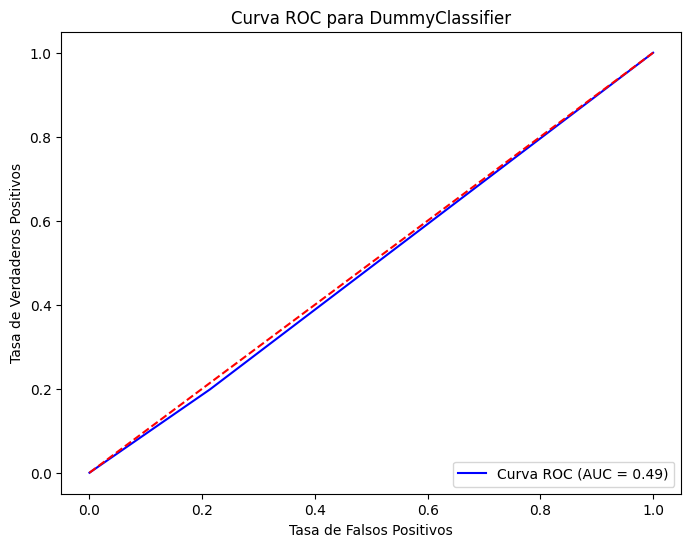

Mejor umbral: inf


In [430]:
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_scaled, y_pred_dummy_proba)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para DummyClassifier')
plt.legend(loc='lower right')
plt.show()

# Encontrar el mejor umbral
optimal_idx = np.argmax(tpr - fpr)  # Mejor umbral donde TPR - FPR es máximo
optimal_threshold = thresholds[optimal_idx]

print(f"Mejor umbral: {optimal_threshold:.2f}")

**Análisis del DummyClassifier**:

Viendo los resultados, podemos considerar al **DummyClassifier** como un punto de referencia, aunque proporciona un rendimiento limitado en este contexto. El modelo tiene un **AUC de ≈0.49**, lo que indica que su capacidad para distinguir entre las clases es prácticamente aleatoria. Además, con un umbral de **≈1.00**, el modelo resulta ineficaz para predecir la lluvia.

Aunque el modelo muestra una **accuracy** del **≈66%**, las métricas de **precision** (**≈0.20**), **recall** (**≈0.20**), y **F1 Score** (**≈0.20**) son bajas. Esto nos dice que el modelo no está capturando adecuadamente los días lluviosos. 

Para mejorar la capacidad predictiva, necesitamos aplicar modelos más sofisticados que manejen mejor el desbalance entre clases y que puedan proporcionar resultados más útiles para este tipo de trabajos.
